In [1]:
import cv2
from ultralytics import YOLO
import time
import numpy as np
import face_recognition
import os
import psutil
import GPUtil
import matplotlib.pyplot as plt  

model = YOLO('yolov8n.pt')

In [2]:
camera = cv2.VideoCapture(0)

cameraWidth = 1280
cameraHeight = 720

if not camera.isOpened():
    print("Kamera tidak dapat diakses.")
    exit()

camera.set(cv2.CAP_PROP_FRAME_WIDTH, cameraWidth)
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, cameraHeight)
camera.set(cv2.CAP_PROP_FPS, 30)

True

Training Data for Face Recognition

In [3]:
known_face_encodings = []
known_face_names = []

dataset_path = "../Dataset"
for filename in os.listdir(dataset_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(dataset_path, filename)
        face_image = face_recognition.load_image_file(image_path)
        face_encodings = face_recognition.face_encodings(face_image)
        if face_encodings:
            known_face_encodings.append(face_encodings[0])
            known_face_names.append("Axel")

In [4]:
id_tags = {}
deteksi_terakhir = {}
waktu_hilang = {}
waktu_cek_face_recognition = {}
waktu = 0  
last_update_time = time.time()
highest_confidence = 0
start_time = time.time()


timeout_duration = 2
face_recognition_interval = 5

frame_count = 0
fps = 0
last_time = time.time()

In [5]:
fps_array = []
accuracy_array = []
cpu_usage_array = []
gpu_usage_array = []
ram_usage_array = []
vram_usage_array = []

Loop When Camera's On

In [6]:
while True:
    ret, frame = camera.read()

    if not ret:
        print("Gagal membaca frame dari kamera.")
        break

    results = model(frame)
    current_ids = []
    highest_confidence = 0

    for result in results[0].boxes:
        x1, y1, x2, y2 = result.xyxy[0].cpu().numpy()  
        conf = result.conf[0].item() 
        cls = result.cls[0].item()

        if conf > 0.5:
            label = model.names[int(cls)]

            if label == "person":
                highest_confidence = max(highest_confidence, conf)

                person_id = len(current_ids) + 1
                current_ids.append(person_id)

                if person_id in id_tags:
                    name = id_tags[person_id]
                else:
                    name = "Tidak dikenal"
                    current_time = time.time()

                    if person_id not in waktu_cek_face_recognition or (current_time - waktu_cek_face_recognition[person_id] > face_recognition_interval):
                        face_frame = frame[int(y1):int(y2), int(x1):int(x2)]
                        rgb_face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)

                        face_encodings = face_recognition.face_encodings(rgb_face_frame)

                        if face_encodings:
                            matches = face_recognition.compare_faces(known_face_encodings, face_encodings[0])
                            face_distances = face_recognition.face_distance(known_face_encodings, face_encodings[0])
                            best_match_index = np.argmin(face_distances)  

                            if matches[best_match_index]:
                                name = known_face_names[best_match_index]
                                accuracy = (1 - face_distances[best_match_index]) * 100
                                id_tags[person_id] = name
                            else:
                                id_tags[person_id] = name

                        waktu_cek_face_recognition[person_id] = current_time

                if name == "Axel":
                    current_time = time.time()
                    waktu += current_time - last_update_time

                last_update_time = time.time()

                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

                #Debugging
                if 'accuracy' in locals():
                    cv2.putText(frame, f"ID {person_id} | {name} | {accuracy:.2f}%",
                                (int(x1), int(y1) - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                else:
                    cv2.putText(frame, f"ID {person_id} | {name}",
                                (int(x1), int(y1) - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)


                deteksi_terakhir[person_id] = time.time()

    current_time = time.time()
    for person_id in list(id_tags.keys()):
        if person_id not in current_ids:
            if current_time - deteksi_terakhir.get(person_id, 0) > timeout_duration:
                print(f"ID {person_id} telah hilang, tag akan dihapus.")
                del id_tags[person_id]
    
    cpu_usage = psutil.cpu_percent()
    memory_info = psutil.virtual_memory()

    gpus = GPUtil.getGPUs()
    gpu_info = gpus[0] if gpus else None 
    if gpu_info:
        gpu_name = gpu_info.name
        gpu_load = gpu_info.load * 100  
        gpu_memory_used = gpu_info.memoryUsed 
        gpu_memory_total = gpu_info.memoryTotal
        gpu_usage_array.append(gpu_load)
        vram_usage_array.append(gpu_memory_used)
    else:
        gpu_load = 0
        gpu_memory_used = 0
        gpu_memory_total = 0  

    frame_count += 1
    current_time = time.time()
    elapsed_time = current_time - last_time

    if elapsed_time >= 1.0:  
        fps = frame_count / elapsed_time 
        frame_count = 0 
        last_time = current_time
        fps_array.append(fps)

    accuracy_array.append(highest_confidence * 100)
    cpu_usage_array.append(cpu_usage)
    ram_usage_array.append(memory_info.percent)

    cv2.putText(frame, f"GPU: {gpu_name}",
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

    cv2.putText(frame, f"GPU Load: {gpu_load:.2f}%",
                (10, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
    cv2.putText(frame, f"Memory: {gpu_memory_used:.0f}/{gpu_memory_total:.0f} MB",
                (10, 70),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

    cv2.putText(frame, f"Axel's Precemse: {int(waktu)} detik",
                (10, 110),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2.putText(frame, f"YOLO Accuration: {highest_confidence * 100:.2f}%",
                (10, 130),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2.putText(frame, f"CPU Usage: {cpu_usage}%",
                (10, 170),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    cv2.putText(frame, f"RAM Usage: {memory_info.percent}%",
                (10, 190),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    cv2.putText(frame, f"FPS: {fps:.2f}", (10, 210), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2.imshow("Presensi Mahasiswa", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

camera.release()
cv2.destroyAllWindows()


0: 384x640 1 person, 79.5ms
Speed: 12.0ms preprocess, 79.5ms inference, 185.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 wine glass, 1 chair, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 wine glass, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 wine glass, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 wine glass, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 wine glass, 6.9ms
Speed: 1.0ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 wine glass, 13.5ms
Speed: 2.0ms preprocess, 13.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 wine gla

Debugging Variable

In [7]:
total_camera_time = time.time() - start_time

#Debugging
print(f"Total Kamera Menyala: {total_camera_time:.2f} detik")
print(accuracy_array)
print('\n')
print(cpu_usage_array)
print('\n')
print(gpu_usage_array)
print('\n')
print(ram_usage_array)
print('\n')
print(vram_usage_array)
print('\n')
print(fps_array)


Total Kamera Menyala: 57.09 detik
[92.34592914581299, 94.17241215705872, 94.25294399261475, 94.13135647773743, 94.24908757209778, 94.05027031898499, 94.22195553779602, 94.21448707580566, 94.12127137184143, 93.8048779964447, 94.05124187469482, 93.38945746421814, 94.53697204589844, 93.6898410320282, 94.35499310493469, 94.37978267669678, 94.81453895568848, 94.34530138969421, 95.14581561088562, 95.04127502441406, 95.15501260757446, 94.99755501747131, 94.41509246826172, 94.22928094863892, 94.09619569778442, 94.09619569778442, 94.51962113380432, 93.34235191345215, 93.34235191345215, 93.54112148284912, 93.30117702484131, 93.92215013504028, 93.92215013504028, 94.04464364051819, 93.86597871780396, 93.39409470558167, 93.26017498970032, 92.60272979736328, 93.89432072639465, 92.8850531578064, 92.38935708999634, 91.62119030952454, 80.3630530834198, 80.3630530834198, 90.0748610496521, 91.91084504127502, 92.26845502853394, 93.50257515907288, 94.97122764587402, 94.7996735572815, 94.87420916557312, 93.

Data Processing

In [8]:
min_length = min(len(accuracy_array), len(cpu_usage_array), len(gpu_usage_array), 
                 len(ram_usage_array), len(vram_usage_array), len(fps_array))

# Variabel untuk rata-rata setiap detik
time_interval = 1  # waktu dalam detik
elapsed_time = 0
sum_accuracy = 0
sum_cpu_usage = 0
sum_gpu_usage = 0
sum_ram_usage = 0
sum_vram_usage = 0
sum_fps = 0

count_accuracy = 0
count_cpu_usage = 0
count_gpu_usage = 0
count_ram_usage = 0
count_vram_usage = 0
count_fps = 0

# Array untuk menyimpan rata-rata per detik
average_accuracy_per_second = []
average_cpu_usage_per_second = []
average_gpu_usage_per_second = []
average_ram_usage_per_second = []
average_vram_usage_per_second = []
average_fps_per_second = []

# Iterasi melalui array metrik dan hitung rata-rata per detik
for i in range(min_length):
    sum_accuracy += accuracy_array[i]
    sum_cpu_usage += cpu_usage_array[i]
    sum_gpu_usage += gpu_usage_array[i]
    sum_ram_usage += ram_usage_array[i]
    sum_vram_usage += vram_usage_array[i]
    sum_fps += fps_array[i]

    count_accuracy += 1
    count_cpu_usage += 1
    count_gpu_usage += 1
    count_ram_usage += 1
    count_vram_usage += 1
    count_fps += 1

    elapsed_time += 1  # Asumsikan waktu berjalan 1 detik per iterasi

    if elapsed_time >= time_interval:
        # Hitung rata-rata untuk interval waktu saat ini
        average_accuracy_per_second.append(sum_accuracy / count_accuracy)
        average_cpu_usage_per_second.append(sum_cpu_usage / count_cpu_usage)
        average_gpu_usage_per_second.append(sum_gpu_usage / count_gpu_usage)
        average_ram_usage_per_second.append(sum_ram_usage / count_ram_usage)
        average_vram_usage_per_second.append(sum_vram_usage / count_vram_usage)
        average_fps_per_second.append(sum_fps / count_fps)

        # Reset untuk interval berikutnya
        sum_accuracy = 0
        sum_cpu_usage = 0
        sum_gpu_usage = 0
        sum_ram_usage = 0
        sum_vram_usage = 0
        sum_fps = 0

        count_accuracy = 0
        count_cpu_usage = 0
        count_gpu_usage = 0
        count_ram_usage = 0
        count_vram_usage = 0
        count_fps = 0

        elapsed_time = 0

# Jika masih ada nilai yang tersisa setelah loop
if count_accuracy > 0:
    average_accuracy_per_second.append(sum_accuracy / count_accuracy)
if count_cpu_usage > 0:
    average_cpu_usage_per_second.append(sum_cpu_usage / count_cpu_usage)
if count_gpu_usage > 0:
    average_gpu_usage_per_second.append(sum_gpu_usage / count_gpu_usage)
if count_ram_usage > 0:
    average_ram_usage_per_second.append(sum_ram_usage / count_ram_usage)
if count_vram_usage > 0:
    average_vram_usage_per_second.append(sum_vram_usage / count_vram_usage)
if count_fps > 0:
    average_fps_per_second.append(sum_fps / count_fps)

Plotting/Visualing Data

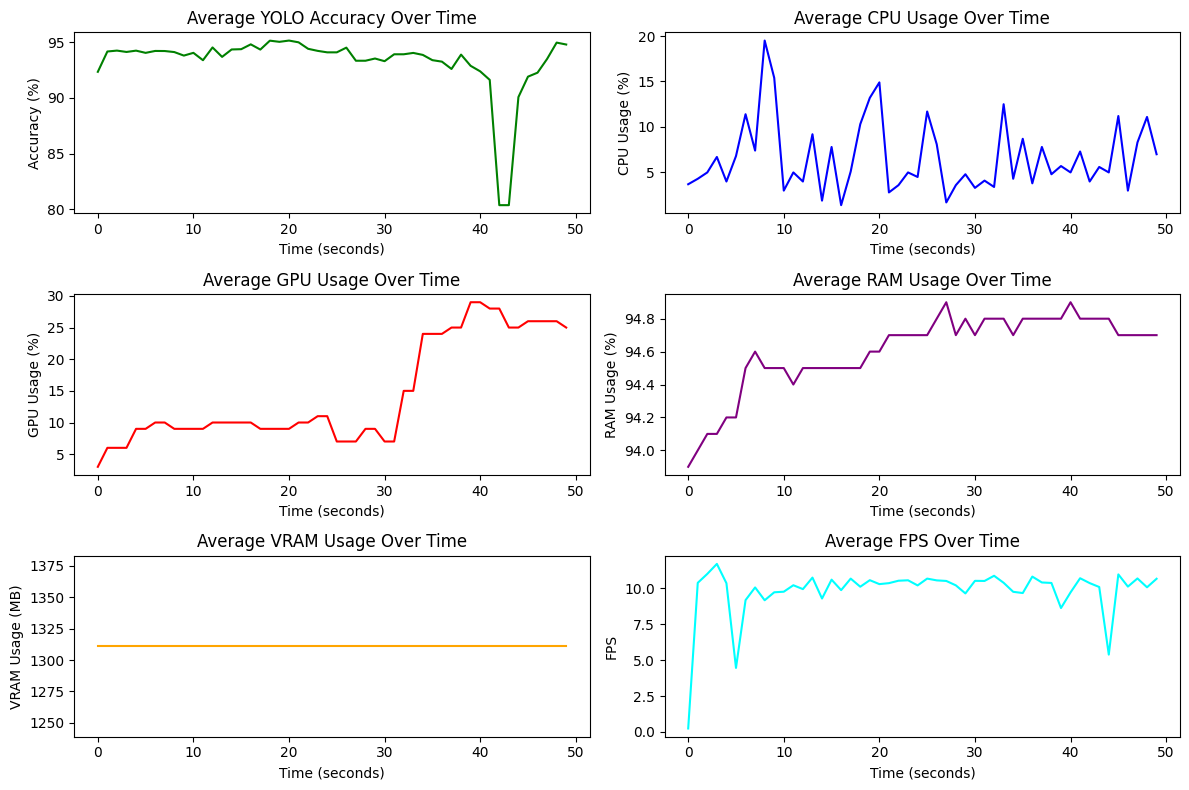

In [9]:
# Plot grafik untuk setiap metrik
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.plot(range(len(average_accuracy_per_second)), average_accuracy_per_second, label='Average YOLO Accuracy (%)', color='green')
plt.xlabel('Time (seconds)')
plt.ylabel('Accuracy (%)')
plt.title('Average YOLO Accuracy Over Time')

plt.subplot(3, 2, 2)
plt.plot(range(len(average_cpu_usage_per_second)), average_cpu_usage_per_second, label='Average CPU Usage (%)', color='blue')
plt.xlabel('Time (seconds)')
plt.ylabel('CPU Usage (%)')
plt.title('Average CPU Usage Over Time')

plt.subplot(3, 2, 3)
plt.plot(range(len(average_gpu_usage_per_second)), average_gpu_usage_per_second, label='Average GPU Usage (%)', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('GPU Usage (%)')
plt.title('Average GPU Usage Over Time')

plt.subplot(3, 2, 4)
plt.plot(range(len(average_ram_usage_per_second)), average_ram_usage_per_second, label='Average RAM Usage (%)', color='purple')
plt.xlabel('Time (seconds)')
plt.ylabel('RAM Usage (%)')
plt.title('Average RAM Usage Over Time')

plt.subplot(3, 2, 5)
plt.plot(range(len(average_vram_usage_per_second)), average_vram_usage_per_second, label='Average VRAM Usage (MB)', color='orange')
plt.xlabel('Time (seconds)')
plt.ylabel('VRAM Usage (MB)')
plt.title('Average VRAM Usage Over Time')

plt.subplot(3, 2, 6)
plt.plot(range(len(average_fps_per_second)), average_fps_per_second, label='Average FPS', color='cyan')
plt.xlabel('Time (seconds)')
plt.ylabel('FPS')
plt.title('Average FPS Over Time')

plt.tight_layout()
plt.show()